In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm
from keras.utils import np_utils
from imgaug import augmenters as iaa
import helpers

Using TensorFlow backend.


In [2]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
# Training file directory
dataset_path = os.path.join(ROOT_DIR, 'dataset', 'ISIC2016')
model_path = os.path.join(ROOT_DIR, "models")
dataset_path

'C:\\Users\\Hasib\\Desktop\\works\\lesion-learnt\\dataset\\ISIC2016'

In [3]:
# load data
x_train = np.load("{}/x_train.npy".format(dataset_path))
y_train = np.load("{}/y_train.npy".format(dataset_path))

x_train.shape, y_train.shape

((900, 299, 299, 3), (900, 2))

In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

# ULTRA AUG

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq_ultra = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            #pad_mode=iaa.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


# heavy augmentation
seq_custom = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
], random_order=True) # apply augmenters in random order


#----------------------------------------------------------------------------

#Data Augmentation

seq1 = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    
    iaa.Crop(percent=(0, 0.2)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
    
    iaa.Sometimes(0.8, 
        iaa.CoarseDropout(0.03, size_percent=0.1)
    ),
    iaa.Sequential([
        iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        iaa.WithChannels(0, iaa.Add((50, 100))),
        iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
    ]),
    
    
], random_order=True) # apply augmenters in random order

seq2 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
         scale={"x": (0.6, 1.2), "y": (0.6, 1.2)},
     ),
    iaa.CoarseDropout((0.0, 0.1), size_percent=(0.02, 0.2)),
    
    iaa.Sometimes( 0.8, iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)),
    
], random_order=True) # apply augmenters in random order

seq3 = iaa.Sequential([
    
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
    
    iaa.Sometimes( 0.4, iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    iaa.Affine(
        rotate=(-90, 90),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
    ),
    iaa.Affine(
        shear=(-50, 50)
    ),
    
    iaa.Sometimes(0.8, 
        iaa.CoarseDropout(0.03, size_percent=0.10)
    ),   
    
    iaa.ContrastNormalization((0.3, 1.8))
], random_order=True) # apply augmenters in random order



C:\Users\Hasib\Anaconda3\envs\skin\lib\site-packages\imgaug\imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [6]:
# Balance dataset

seq_standard = iaa.Sequential([
    iaa.Fliplr(0.5), 
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-360, 360))
], random_order=True)

def augment_data_minimal( x_values, y_values ):
    counter = 0
    RESIZE_DIM = 299
    X_values_augmented = []
    Y_values_augmented = []
    for x in x_values:
        for p in range(5):
            
            # seq 1
            Y_values_augmented.append( y_values[counter] )
            images_aug = seq_standard.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))
        counter = counter + 1
    
    # Quick math!
    # prev number of images = n
    # augmented number of images = n * 4 ( 2 seq 2 times)
    
    X_values_augmented = np.asarray( X_values_augmented )
    Y_values_augmented = np.asarray( Y_values_augmented )
    return (X_values_augmented, Y_values_augmented)


In [7]:
(x_aug, y_aug) = augment_data_minimal( x_train, y_train)
x_aug.shape, y_aug.shape

((4500, 299, 299, 3), (4500, 2))

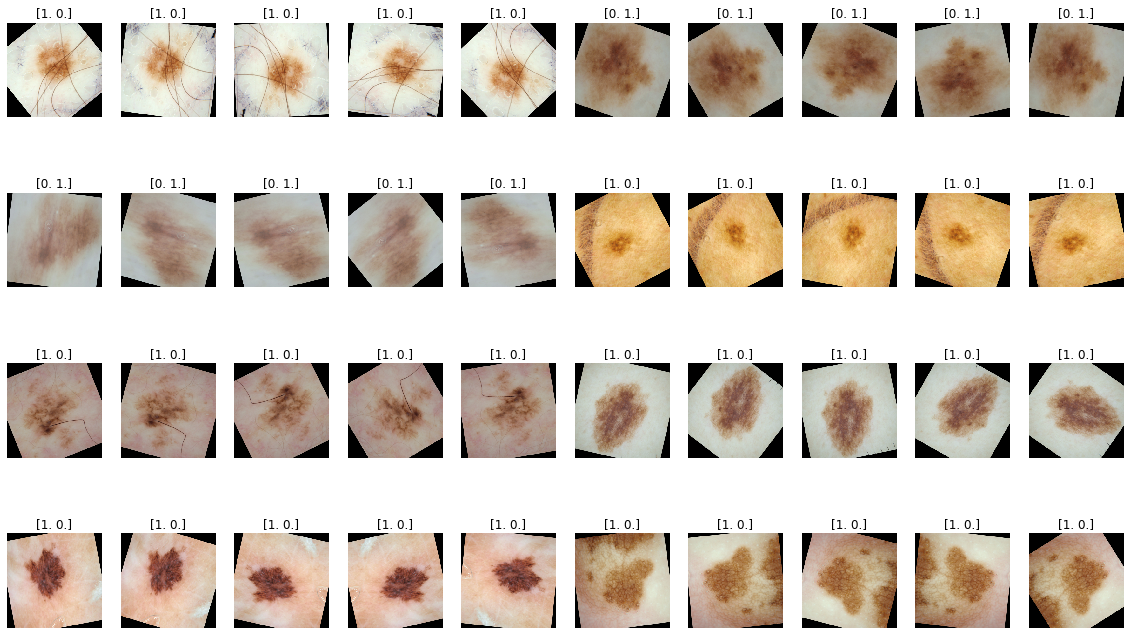

In [10]:
helpers.imshow_group(x_aug[-40:], y_aug[-40:])

In [11]:
x_train_aug = np.concatenate( (x_train, x_aug), axis = 0)
y_train_aug = np.concatenate( (y_train, y_aug), axis = 0)

# new normal samples
x_train_aug.shape, y_train_aug.shape

((5400, 299, 299, 3), (5400, 2))

In [18]:
flat = np.array([np.argmax(pred) for pred in y_train_aug])
np.count_nonzero(flat == 1), np.count_nonzero(flat == 0)

(1038, 4362)

In [19]:
np.save("dataset/ISIC2016/x_aug_5400.npy", x_train_aug)
np.save("dataset/ISIC2016/y_aug_5400.npy", y_train_aug)
print("Done!")

Done!
